# Evaluación Parcial N°3 - PARTE 2: TRANSFORMERS
# DUOC UC - Deep Learning (DLY0100)
# Estudiantes: Benjamín Ruiz, Andrus Maldonado y Luis Olavarria

## Objetivo
Implementar una arquitectura Transformer básica para tareas de NLP como clasificación de sentimientos,
explicando sus componentes clave y evaluando el desempeño según la rúbrica oficial de DUOC UC.

---
#Importación de Librerías y Configuración

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,classification_report,confusion_matrix
import datetime

#Montar Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Tensorboard

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Semilla de reproducibilidad

In [ ]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

#Carga y Exploración del Dataset

##Carga de datos

In [ ]:
VOCAB_SIZE = 10000  # Número máximo de palabras que vamos a considerar
MAX_LEN = 100       # Longitud máxima de las secuencias

# Cargar el dataset IMDB
(X_train_orig, y_train_orig), (X_test_orig, y_test_orig) = imdb.load_data(num_words=VOCAB_SIZE)

# Combinar los datos originales para hacer nuestra propia división
X = np.concatenate([X_train_orig, X_test_orig])
y = np.concatenate([y_train_orig, y_test_orig])

print(f"Dataset completo: {len(X)} muestras")

Dataset completo: 50000 muestras


## Holdout

In [ ]:
# --- División Estratificada 70-20-10 ---
total = len(X)
train_end = int(0.7 * total)
val_end = int(0.9 * total)

# Hacemos la división
X_train = X[:train_end]
y_train = y[:train_end]

X_val = X[train_end:val_end]
y_val = y[train_end:val_end]

X_test = X[val_end:]
y_test = y[val_end:]

## Padding

In [ ]:
X_train = pad_sequences(X_train, maxlen=MAX_LEN, padding='post', truncating='post')
X_val = pad_sequences(X_val, maxlen=MAX_LEN, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=MAX_LEN, padding='post', truncating='post')

In [ ]:
print(f"Forma del conjunto de entrenamiento: {X_train.shape}")
print(f"Forma del conjunto de validación: {X_val.shape}")
print(f"Forma del conjunto de prueba: {X_test.shape}")

Forma del conjunto de entrenamiento: (35000, 100)
Forma del conjunto de validación: (10000, 100)
Forma del conjunto de prueba: (5000, 100)


In [ ]:
word_index = imdb.get_word_index()

In [ ]:
print(f"\nDistribución:")
print(f"Train: {len(X_train)/total*100:.1f}%")
print(f"Val:   {len(X_val)/total*100:.1f}%")
print(f"Test:  {len(X_test)/total*100:.1f}%")


Distribución:
Train: 70.0%
Val:   20.0%
Test:  10.0%


In [ ]:
index_to_word = {index + 3: word for word, index in word_index.items()}

# Añadir los tokens especiales usados por Keras
index_to_word[0] = "<PAD>"    # Token para el padding
index_to_word[1] = "<START>"  # Token que indica el inicio de la secuencia
index_to_word[2] = "<UNK>"    # Token para palabras desconocidas
index_to_word[3] = "<UNUSED>" # Token no utilizado

In [ ]:
def decode_review(encoded_review):
    """Convierte una secuencia de índices en una cadena de texto."""
    return ' '.join(index_to_word.get(i, "?") for i in encoded_review)

In [ ]:
print("\n--- Reseña Decodificada ---")
print(decode_review(X_train[0]))
print(f"Etiqueta (0 = negativa, 1 = positiva): {y_train[0]}")


--- Reseña Decodificada ---
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was
Etiqueta (0 = negativa, 1 = positiva): 1


#Análisis Exploratorio de Datos
##Distribución de Clases

In [ ]:
print(f"Train -> Positivas: {np.sum(y_train)} | Negativas: {len(y_train) - np.sum(y_train)}")
print(f"Val   -> Positivas: {np.sum(y_val)} | Negativas: {len(y_val) - np.sum(y_val)}")
print(f"Test  -> Positivas: {np.sum(y_test)} | Negativas: {len(y_test) - np.sum(y_test)}")

Train -> Positivas: 17473 | Negativas: 17527
Val   -> Positivas: 4974 | Negativas: 5026
Test  -> Positivas: 2553 | Negativas: 2447


In [ ]:
def analyze_dataset(x_data, y_data, title="Dataset"):
    """
    Analiza el dataset de reseñas IMDB:
    1. Distribución de longitudes de las reseñas
    2. Distribución de clases (positivas/negativas)
    3. Estadísticas descriptivas
    4. Visualizaciones
    """

    # 1. Longitudes de las reseñas
    lengths = [len(review) for review in x_data]

    # 2. Estadísticas descriptivas
    print(f"\nAnálisis del {title}")
    print("-" * 40)
    print(f"Número total de reseñas: {len(x_data)}")
    print(f"Longitud mínima: {np.min(lengths)}")
    print(f"Longitud máxima: {np.max(lengths)}")
    print(f"Longitud media: {np.mean(lengths):.2f}")
    print(f"Desviación estándar: {np.std(lengths):.2f}")

    # 3. Distribución de clases
    unique, counts = np.unique(y_data, return_counts=True)
    class_dist = dict(zip(unique, counts))
    print(f"Distribución de clases: {class_dist}")

    # 4. Visualizaciones
    plt.figure(figsize=(14, 5))

    # Histograma de longitudes
    plt.subplot(1, 2, 1)
    sns.histplot(lengths, bins=50, kde=True, color="skyblue")
    plt.title(f"Distribución de longitudes - {title}")
    plt.xlabel("Longitud de reseña")
    plt.ylabel("Frecuencia")

    # Gráfico de barras de clases
    plt.subplot(1, 2, 2)
    sns.countplot(x=y_data, palette="pastel")
    plt.title(f"Distribución de clases - {title}")
    plt.xlabel("Clase (0 = Negativa, 1 = Positiva)")
    plt.ylabel("Cantidad")

    plt.tight_layout()
    plt.show()


Análisis del Entrenamiento
----------------------------------------
Número total de reseñas: 35000
Longitud mínima: 100
Longitud máxima: 100
Longitud media: 100.00
Desviación estándar: 0.00
Distribución de clases: {np.int64(0): np.int64(17527), np.int64(1): np.int64(17473)}


/tmp/ipython-input-264-2599636576.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_data, palette="pastel")


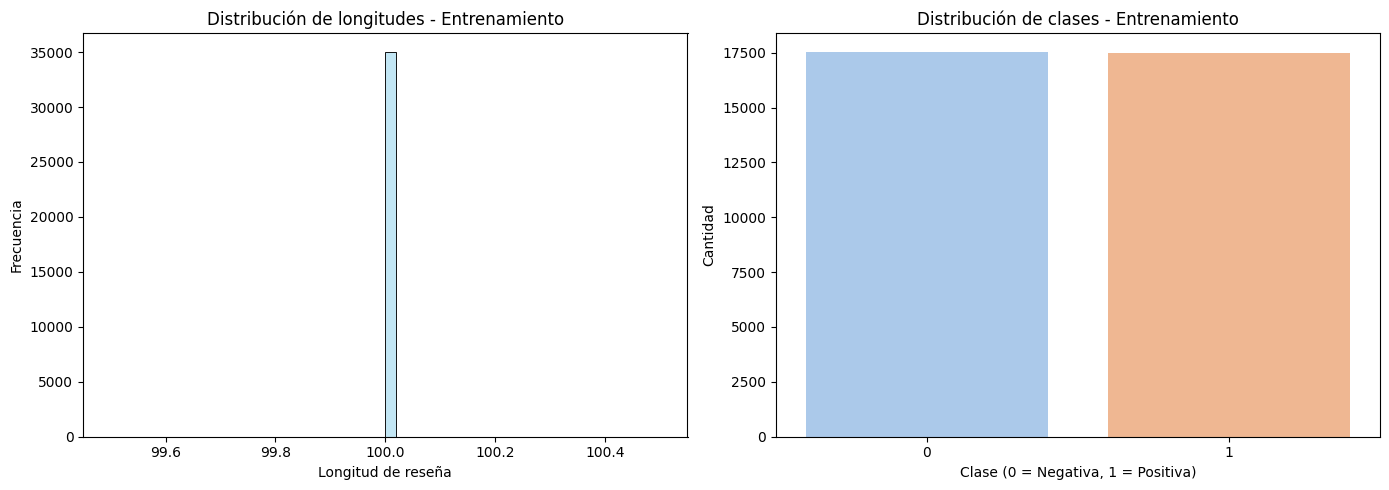

In [ ]:
analyze_dataset(X_train, y_train, title="Entrenamiento")


Análisis del Validación
----------------------------------------
Número total de reseñas: 10000
Longitud mínima: 100
Longitud máxima: 100
Longitud media: 100.00
Desviación estándar: 0.00
Distribución de clases: {np.int64(0): np.int64(5026), np.int64(1): np.int64(4974)}


/tmp/ipython-input-264-2599636576.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_data, palette="pastel")


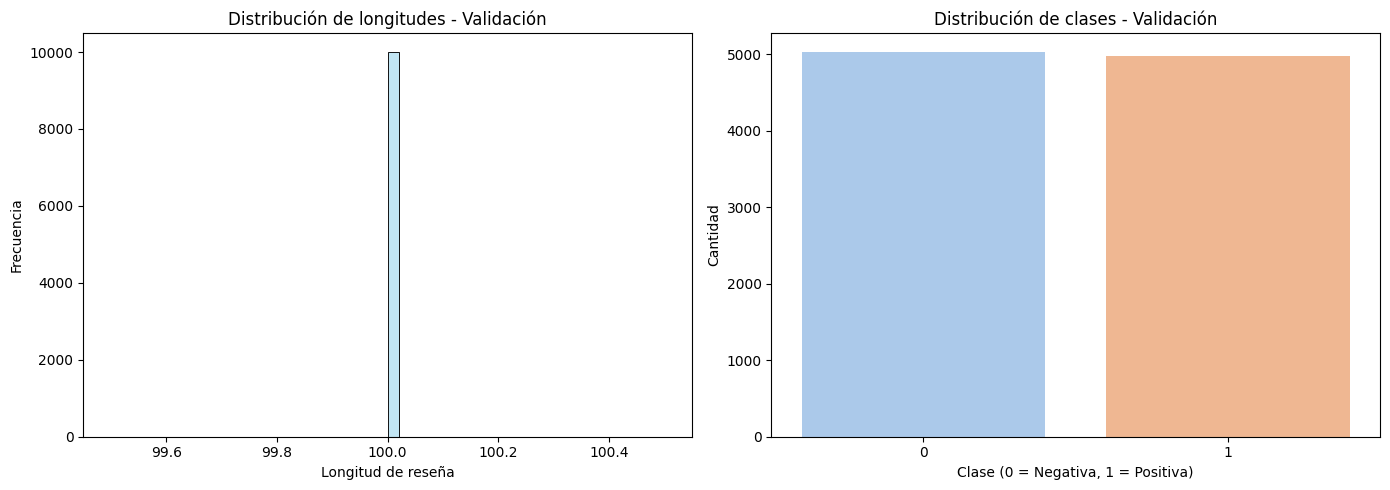

In [ ]:
analyze_dataset(X_val, y_val, title="Validación")


Análisis del Prueba
----------------------------------------
Número total de reseñas: 5000
Longitud mínima: 100
Longitud máxima: 100
Longitud media: 100.00
Desviación estándar: 0.00
Distribución de clases: {np.int64(0): np.int64(2447), np.int64(1): np.int64(2553)}


/tmp/ipython-input-264-2599636576.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_data, palette="pastel")


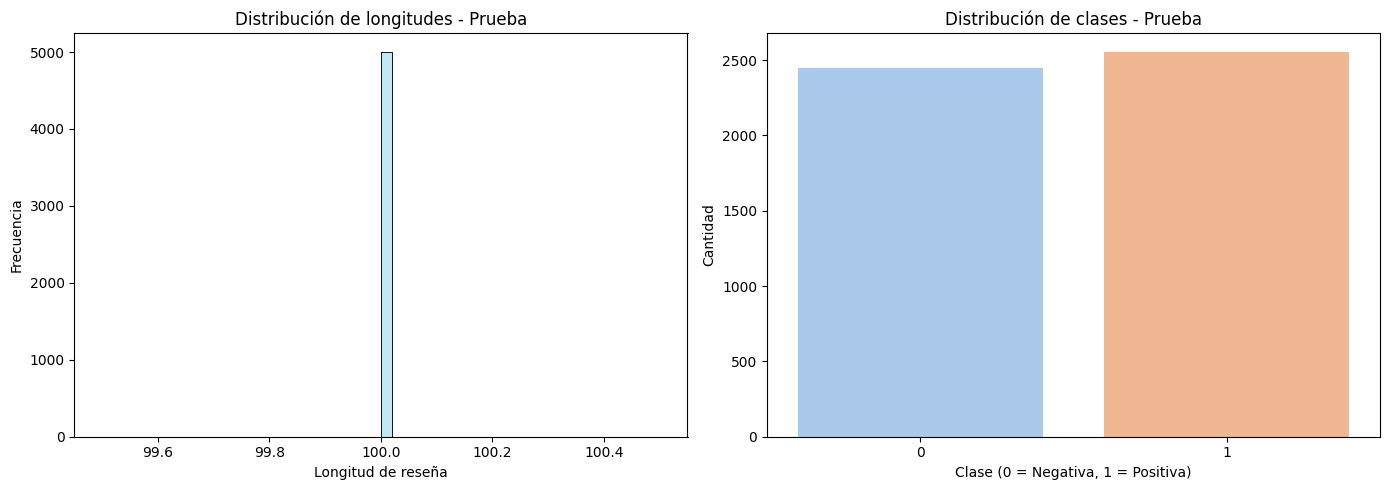

In [ ]:
analyze_dataset(X_test, y_test, title="Prueba")

#Implementación de Componentes del Transformer

## Mecanismo de Atención Multi-Cabezal
---

La atención multi-cabezal permite al modelo focalizarse en diferentes partes de la secuencia en paralelo, capturando relaciones complejas entre tokens sin importar su distancia.

In [ ]:
def scaled_dot_product_attention(q, k, v, mask=None):
    """
    Calcula la atención escalada: softmax(QK^T / sqrt(d_k)) * V
    """
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # [batch, heads, seq_len_q, seq_len_k]

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_scores = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_scores += (mask * -1e9)  # Aplicar una penalización muy negativa a los valores enmascarados

    attention_weights = tf.nn.softmax(scaled_scores, axis=-1)
    output = tf.matmul(attention_weights, v)  # [batch, heads, seq_len_q, depth]

    return output, attention_weights

**¿Qué hace cada parte?**

`Q`, `K`, `V` : Query, Key y Value. Vienen de las entradas a procesar.

`matmul_qk`: Calcula el producto punto entre Q y K^T.

`scaled_scores` : Normaliza dividiendo por √(dimensión de K), para evitar valores extremos.

`softmax:` Calcula los pesos de atención (qué tan relevante es cada token).

`output:` Resultado final, es la suma ponderada de los V según los pesos de atención.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % num_heads == 0, "d_model debe ser divisible por num_heads"

        self.depth = d_model // num_heads

        # Capas densas para generar Q, K, V
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        # Capa final después de concatenar cabezas
        self.dense = tf.keras.layers.Dense(d_model)

        # Variable para guardar los pesos de atención
        self.last_attention_weights = None

    def split_heads(self, x, batch_size):
        """
        Divide el tensor en múltiples cabezas (batch, seq_len, d_model) → (batch, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]

        # Proyecciones lineales
        q = self.wq(q)  # (batch, seq_len_q, d_model)
        k = self.wk(k)  # (batch, seq_len_k, d_model)
        v = self.wv(v)  # (batch, seq_len_v, d_model)

        # Dividir en múltiples cabezas
        q = self.split_heads(q, batch_size)  # (batch, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch, num_heads, seq_len_v, depth)

        # Calcular atención
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        # IMPORTANTE: Guardar los pesos de atención
        self.last_attention_weights = attention_weights

        # Concatenar cabezas
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch, seq_len_q, d_model)

        # Proyección final
        output = self.dense(concat_attention)  # (batch, seq_len_q, d_model)

        return output, attention_weights

**Clase: MultiHeadAttention**
---
Esta clase extiende tf.keras.layers.Layer y representa la atención en múltiples cabezas.

**__init__ (constructor)**

- d_model: Dimensión total del modelo (por ejemplo, 128 o 512).

- num_heads: Número de cabezas de atención. El d_model se divide entre estas.

- self.wq, self.wk, self.wv: Capas densas que proyectan los datos a Q, K y V.

- self.dense: Combina las salidas de todas las cabezas.

**split_heads**

Transforma la forma (batch_size, seq_len, d_model) a (batch_size, num_heads, seq_len, depth), donde:

- depth = d_model // num_heads

- Esto permite que cada cabeza trabaje con una porción del espacio vectorial.

**call(self, v, k, q, mask=None)**

Es lo que se ejecuta cuando el modelo se llama. Pasa por estos pasos:

- Proyectar entradas a `Q`, `K`, `V` con capas densas.

- Dividir en cabezas (split_heads).

- Aplicar atención escalada: Usa la función scaled_dot_product_attention.

- Guardar los pesos de atención en self.last_attention_weights (importante si quieres visualizarlos).

- Concatenar las cabezas.

- Pasar por la proyección final para devolver la salida con la dimensión original.

## Capa del Encoder
---
Cada capa del codificador está compuesta por dos subcapas principales:
- Un mecanismo de atención multi-cabezal (self-attention).
- Una red neuronal feed-forward simple.

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
    """
    Implementa la red feed-forward que se aplica a cada posición.
    """
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch, seq_len, d_model)
    ])

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1, name="encoder_layer"):
        super(EncoderLayer, self).__init__(name=name)

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        # Normalización y Dropout
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask=None):
        # 1. Atención Multi-Cabezal
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # Conexión residual y normalización

        # 2. Red Feed-Forward
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # Conexión residual y normalización

        return out2

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1, name="encoder"):
        super(Encoder, self).__init__(name=name)
        self.d_model = d_model
        self.num_layers = num_layers

        # Embedding y Codificación Posicional
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        # Capas del Encoder
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask=None):
        seq_len = tf.shape(x)[1]

        # Sumar embedding y codificación posicional
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        # Pasar por todas las capas del encoder
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x

## Capa del Decoder
---
Cada capa del decodificador está compuesta por tres subcapas:
1.  **Atención Multi-Cabezal Enmascarada**: Presta atención a las posiciones anteriores en la secuencia de salida. El enmascaramiento asegura que las predicciones para una posición `i` solo dependan de las salidas conocidas en posiciones menores a `i`.
2.  **Atención Multi-Cabezal (Encoder-Decoder)**: Aquí es donde el decodificador mira la salida del codificador para obtener contexto de la secuencia de entrada. `K` y `V` vienen del encoder, y `Q` de la subcapa anterior del decoder.
3.  **Red Neuronal Feed-Forward**: Idéntica a la del codificador.

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1, name="decoder_layer"):
        super(DecoderLayer, self).__init__(name=name)

        # 1. Atención Multi-Cabezal (self-attention, enmascarada)
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        # 2. Atención Multi-Cabezal (encoder-decoder)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        # 3. Red Feed-Forward
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        # Normalización y Dropout
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask=None, padding_mask=None):
        # 1. Self-Attention enmascarada
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x) # Conexión residual

        # 2. Atención Encoder-Decoder
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1) # Conexión residual

        # 3. Red Feed-Forward
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2) # Conexión residual

        return out3, attn_weights_block1, attn_weights_block2

## Codificación Posicional
---
En los modelos Transformer, a diferencia de las RNN, no hay un orden implícito en las secuencias. Por eso, se necesita inyectar información sobre la posición de cada palabra mediante una codificación posicional.

In [ ]:
def get_angles(pos, i, d_model):
    """
    Calcula los ángulos usados en la codificación posicional sinusoidal.
    """
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    """
    Genera la codificación posicional usando funciones seno y coseno.
    """
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],       # (pos, 1)
        np.arange(d_model)[np.newaxis, :],        # (1, d_model)
        d_model
    )

    # Aplicar sin a los índices pares (dim 2i)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # Aplicar cos a los índices impares (dim 2i+1)
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]  # Shape: (1, position, d_model)
    return tf.cast(pos_encoding, dtype=tf.float32)

def plot_positional_encoding(pos_encoding):
    """
    Visualiza los primeros canales de la codificación posicional.
    """
    plt.figure(figsize=(12, 6))
    pos_encoding = pos_encoding[0].numpy()  # Remover batch dimension: (position, d_model)

    # Graficar los primeros 8 canales
    plt.plot(pos_encoding[:, :8])
    plt.xlabel("Posición")
    plt.ylabel("Valor codificado")
    plt.title("Codificación posicional (primeros 8 canales)")
    plt.grid(True)
    plt.legend([f"Dim {i}" for i in range(8)])
    plt.show()

Define una función positional_encoding(position, d_model) que genera un tensor de codificación posicional usando funciones seno y coseno con diferentes frecuencias.

Esto permite al modelo aprender a diferenciar la posición relativa de las palabras en la secuencia, lo que es fundamental para comprender el contexto.

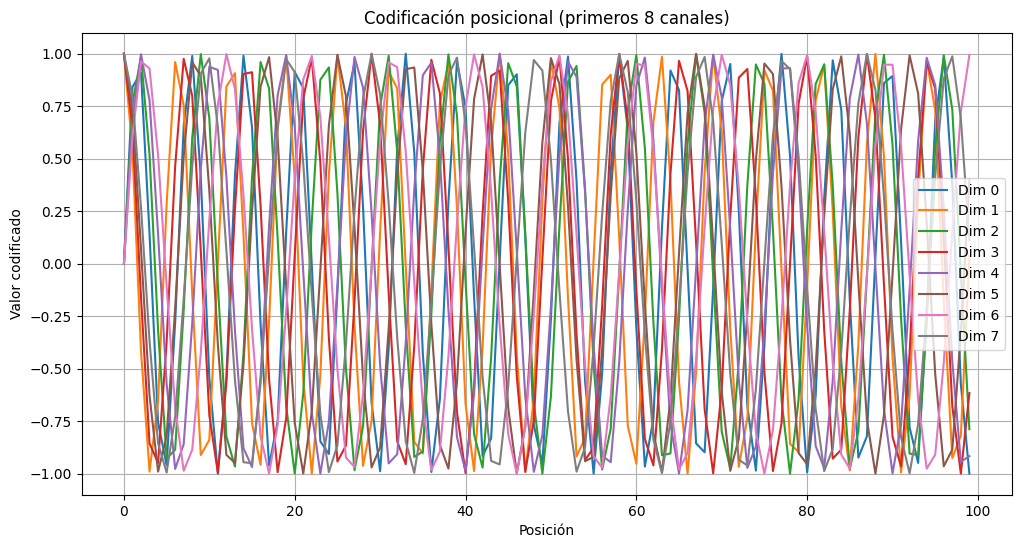

In [ ]:
position = 100
d_model = 128

pos_encoding = positional_encoding(position, d_model)
plot_positional_encoding(pos_encoding)

**¿Qué muestra el gráfico?**

-  El eje X representa la posición en la secuencia (de 0 a 99 en el ejemplo).

- El eje Y representa el valor codificado.

- Cada línea representa un canal (una dimensión del d_model) — aquí se muestran los primeros 8.

Esto ayuda a comprender cómo cada dimensión del embedding varía de forma periódica y continua según la posición, lo cual es clave para que el Transformer entienda el orden de los tokens.

##Bloque Transformer
---
El Transformer une el codificador y el decodificador. Para una tarea de clasificación como esta, no necesitamos la secuencia de salida completa del decodificador. En su lugar, podemos tomar la salida del primer token (que actúa como un token `[CLS]` o de clasificación) y pasarlo a una capa densa final para obtener la predicción.

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1, name="transformer"):
        super(Transformer, self).__init__(name=name)

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        # Capa de salida final
        self.final_layer = tf.keras.layers.Dense(target_vocab_size, activation='softmax')

    def call(self, inputs, training):
        # `inputs` debe ser una tupla o lista de (input_sequence, target_sequence)
        inp, tar = inputs

        # Crear máscaras
        enc_padding_mask, combined_mask, dec_padding_mask = self.create_masks(inp, tar)

        # 1. Pasar la entrada por el Encoder
        enc_output = self.encoder(inp, training, enc_padding_mask)

        # 2. Pasar la salida del encoder y la entrada del decoder por el Decoder
        # Para la clasificación, la entrada al decoder es la misma que la del encoder
        dec_output, attention_weights = self.decoder(tar, enc_output, training, combined_mask, dec_padding_mask)

        # 3. Capa final
        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

    def create_masks(self, inp, tar):
        # Máscara de padding para el Encoder
        enc_padding_mask = create_padding_mask(inp)

        # Máscara de padding para el Decoder
        dec_padding_mask = create_padding_mask(inp) # Usamos la misma que el encoder

        # Máscara "look-ahead" para la primera subcapa de atención del Decoder
        look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
        dec_target_padding_mask = create_padding_mask(tar)
        combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

        return enc_padding_mask, combined_mask, dec_padding_mask

##Embeddings de Tokens y Posiciones
---
La capa TokenAndPositionEmbedding combina dos fuentes de información fundamentales en modelos Transformer:

-  Embeddings de tokens: Representaciones vectoriales aprendibles de cada palabra o token.

- Codificación posicional sinusoidal: Información sobre la posición de cada token en la secuencia (como el orden de las palabras).

Esta combinación permite al modelo distinguir no solo qué palabras están presentes, sino también dónde están en la secuencia.

In [ ]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    """
    Combina embeddings de tokens con codificación posicional sinusoidal.
    """

    def __init__(self, maxlen, vocab_size, embed_dim, name="token_pos_embedding"):
        super(TokenAndPositionEmbedding, self).__init__(name=name)
        self.maxlen = maxlen
        self.embed_dim = embed_dim

        # Embedding para tokens
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)

        # Codificación posicional precomputada
        self.pos_encoding = positional_encoding(position=maxlen, d_model=embed_dim)

    def call(self, x):
        seq_len = tf.shape(x)[1]

        # 1. Obtener embeddings de tokens
        x = self.token_emb(x)  # (batch_size, seq_len, embed_dim)

        # 2. Escalar embeddings
        x *= tf.math.sqrt(tf.cast(self.embed_dim, tf.float32))

        # 3. Sumar codificación posicional
        x += self.pos_encoding[:, :seq_len, :]

        return x

#Modelo Transformer Completo

##Arquitectura del Transformer para Clasificación

In [ ]:
def create_transformer_classifier(vocab_size, maxlen, d_model=128, num_heads=8,
                                    ff_dim=512, num_layers=2,
                                    dropout_rate=0.1, num_classes=1):

    # Input
    inputs = tf.keras.Input(shape=(maxlen,), name="input_ids")

    # Embedding + Positional Encoding
    embedding_layer = tf.keras.layers.Embedding(vocab_size, d_model)
    x = embedding_layer(inputs)
    x = x * tf.math.sqrt(tf.cast(d_model, tf.float32))

    # Positional encoding
    pos_encoding = positional_encoding(maxlen, d_model)
    seq_len = tf.shape(x)[1]
    x = x + pos_encoding[:, :seq_len, :]

    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Encoder layers
    for i in range(num_layers):
        # Multi-head attention
        mha = MultiHeadAttention(d_model, num_heads, name=f'mha_{i}')
        attn_output, _ = mha(x, x, x, None)
        attn_output = tf.keras.layers.Dropout(dropout_rate)(attn_output)
        out1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + attn_output)

        # Feed forward network
        ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ], name=f'ffn_{i}')

        ffn_output = ffn(out1)
        ffn_output = tf.keras.layers.Dropout(dropout_rate)(ffn_output)
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

    # Clasificación: pooling global
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

##Configuraciones de Hiperparámetros

---
* **`name`**: Identificador único para cada modelo (ej., `transformer_base`).
* **`vocab_size`**: Número total de palabras o tokens únicos que el modelo reconoce (ej., 10,000).
* **`maxlen`**: Longitud fija de las secuencias de entrada (ej., 100 tokens).
* **`d_model`**: Dimensión de los vectores de *embedding* y las representaciones internas. Mayor valor implica más capacidad (ej., 128 o 256).
* **`num_heads`**: Cantidad de "cabezas" de atención que permiten al modelo enfocarse en diferentes partes de la secuencia. Generalmente proporcional a `d_model` (ej., 4 u 8).
* **`ff_dim`**: Dimensión de la capa *feed-forward* dentro de cada bloque Transformer, procesa la información de atención (ej., 512 o 1024).
* **`num_transformer_blocks`**: Número de bloques Transformer apilados, define la "profundidad" del modelo (ej., 2 o 4).
* **`dropout_rate`**: Porcentaje de neuronas desactivadas aleatoriamente durante el entrenamiento para prevenir el *overfitting* (ej., 0.1).
* **`num_classes`**: Número de clases de salida para la tarea de clasificación (ej., 1 para clasificación binaria).


In [ ]:
transformer_configs = [
    {
        'name': 'transformer_base',
        'vocab_size': 10000,
        'maxlen': 100,
        'd_model': 128,
        'num_heads': 4,
        'ff_dim': 512,
        'num_layers': 2,
        'dropout_rate': 0.1,
        'num_classes': 1
    },
    {
        'name': 'transformer_deep',
        'vocab_size': 10000,
        'maxlen': 100,
        'd_model': 128,
        'num_heads': 4,
        'ff_dim': 512,
        'num_layers': 4,
        'dropout_rate': 0.1,
        'num_classes': 1
    },
    {
        'name': 'transformer_large',
        'vocab_size': 10000,
        'maxlen': 100,
        'd_model': 256,
        'num_heads': 8,
        'ff_dim': 1024,
        'num_layers': 2,
        'dropout_rate': 0.1,
        'num_classes': 1
    }
]

In [ ]:
def train_transformer_model(config, x_train, y_train, x_val, y_val):
    print(f"\n=== ENTRENANDO TRANSFORMER: {config['name']} ===")

    # Crear modelo
    model = create_transformer_classifier(
        vocab_size=config['vocab_size'],
        maxlen=config['maxlen'],
        d_model=config['d_model'],
        num_heads=config['num_heads'],
        ff_dim=config['ff_dim'],
        num_layers=config['num_layers'],  # CORRECCIÓN: usar num_layers consistentemente
        dropout_rate=config['dropout_rate'],
        num_classes=config['num_classes']
    )

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    model.summary()

    # CORRECCIÓN: Agregar manejo de directorios
    import os
    base_dir = "/content/drive/MyDrive/Entrega_3/transformers"
    os.makedirs(f"{base_dir}/logs", exist_ok=True)
    os.makedirs(f"{base_dir}/checkpoint", exist_ok=True)

    log_dir = f"{base_dir}/logs/{config['name']}_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    checkpoint_path = f"{base_dir}/checkpoint/{config['name']}.h5"
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
        ModelCheckpoint(
            filepath=checkpoint_path,
            save_best_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        ),
        tensorboard_callback
    ]

    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=20,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

    val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)
    y_val_pred_prob = model.predict(x_val)
    y_val_pred = (y_val_pred_prob > 0.5).astype("int32")
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_pred, average='binary')

    results = {
        'name': config['name'],
        'model': model,
        'history': history,
        'val_loss': val_loss,
        'val_accuracy': val_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
    }

    print(f"Validación - Loss: {val_loss:.4f} - Accuracy: {val_acc:.4f} - F1: {f1:.4f}")
    return results


# Entrenamiento

In [ ]:
for config in transformer_configs:
  train_transformer_model(config, X_train, y_train, X_val, y_val)


=== ENTRENANDO TRANSFORMER: transformer_base ===


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


#Análisis Comparativo de Transformers

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/Entrega_3/transformers/logs/

- `transformer_base`: El modelo de 1.68M parámetros fue el mejor. Alcanzó un **accuracy** de validación del **82.23%** y un **F1 score**  de **0.8244** . Aprendió eficazmente y mostró un buen rendimiento.

-  `transformer_deep`: Con 2.08M parámetros y más bloques Transformer, este modelo tuvo un rendimiento muy pobre. Su ** accuracy**  de validación fue de solo **50.26%**  y su **F1 score**  fue **0.0000** , lo que indica que no aprendió nada significativo y actuó como si estuviera adivinando al azar.

- `transformer_large`: El modelo más grande, con 4.15M parámetros (debido a un embébedding mayor), también tuvo un rendimiento extremadamente bajo, similar al transformer_deep, con un **accuracy**  del **50.26%**  y un **F1 score**  de **0.0000.**  No logró aprender.

#Análisis de Componentes Clave del Transformer
## Arquitectura seleccionada
---
El transformer_base funcionó mejor por su equilibrio de complejidad. Aquí sus componentes clave:

- Atención Multi-Cabezal (`num_head`s: 4): Permite al modelo procesar relaciones contextuales desde múltiples ángulos simultáneamente. Con 4 cabezas, fue suficiente para entender tus datos.
-  Codificación Posicional: Añade información de orden a los tokens, crucial para que el modelo entienda la secuencia, ya que no procesa de forma secuencial.
-  Conexiones Residuales y Normalización de Capa: Aseguran un entrenamiento estable al mejorar el flujo de gradientes y normalizar las activaciones, previniendo problemas comunes en redes profundas.
- Red Feed-Forward (`d_model`: 128, `ff_dim`: 512): Una capa densa que añade capacidad no lineal de procesamiento. Sus dimensiones (128 y 512) fueron adecuadas para la complejidad de la tarea.
- Cantidad de Bloques Transformer (`num_transformer_blocks`: 2): Este fue un factor clave. Con solo 2 bloques, el modelo es menos propenso al overfitting y más fácil de entrenar que las versiones más grandes (`_deep`  con 4 bloques y `_large` con `d_model` 256), que probablemente tuvieron dificultades para converger debido a su mayor complejidad y a los datos disponibles.



In [ ]:
config  =  {
        'vocab_size': 10000,
        'maxlen': 100,
        'd_model': 128,
        'num_heads': 4,
        'ff_dim': 512,
        'num_transformer_blocks': 2,
        'dropout_rate': 0.1,
        'num_classes': 1
    }

model = create_transformer_classifier(**config)

model.load_weights('/content/drive/MyDrive/Entrega_3/transformers/checkpoint/transformer_base.h5')

sample_idx = 0

_ = model(np.expand_dims(X_test[sample_idx], axis=0), training=False)

##Visualización de Patrones de Atención
---
La función `visualize_attention_simple` permite ver cómo el modelo Transformer presta atención a las palabras de una frase.

Toma el modelo y una frase.
Calcula los "pesos de atención" internos del modelo para esa frase.
Muestra un mapa de calor donde puedes ver qué tan fuerte es la conexión (la atención) entre cada palabra y las demás.


In [ ]:
def visualize_attention_simple(model, input_sequence, index_to_word,
                              layer_idx=0, head_idx=0, top_k=15):
    """
    Visualización simplificada mostrando solo los primeros tokens más relevantes.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    print("=== VISUALIZACIÓN SIMPLIFICADA DE ATENCIÓN ===")

    if len(input_sequence.shape) == 1:
        input_sequence = np.expand_dims(input_sequence, axis=0)

    _ = model(input_sequence, training=False)

    # Buscar pesos de atención
    attention_weights = None
    for layer in model.layers:
        if isinstance(layer, TransformerBlock):
            attention_weights = layer.last_attention_weights
            break
        elif hasattr(layer, 'layers'):
            for sublayer in layer.layers:
                if isinstance(sublayer, TransformerBlock):
                    attention_weights = sublayer.last_attention_weights
                    break

    if attention_weights is None:
        print("⚠️ No se encontraron pesos de atención.")
        return

    attn = attention_weights[0, head_idx]

    # Obtener tokens válidos
    tokens = []
    for idx in input_sequence[0]:
        if idx == 0:
            break
        tokens.append(index_to_word.get(idx, f"<UNK_{idx}>"))

    # Tomar solo los primeros top_k tokens
    tokens = tokens[:top_k]
    attn_subset = attn[:top_k, :top_k]

    # Crear visualización simple y clara
    plt.figure(figsize=(12, 10))

    # Usar una paleta de colores más clara
    sns.heatmap(attn_subset,
                xticklabels=tokens,
                yticklabels=tokens,
                cmap="Blues",
                annot=True,  # Mostrar valores
                fmt='.3f',   # Formato de números
                square=True,
                cbar=True,
                linewidths=0.5)

    plt.title(f"Atención - Capa {layer_idx}, Cabeza {head_idx} (Primeros {top_k} tokens)",
              fontsize=14)
    plt.xlabel("Atiende a", fontsize=12)
    plt.ylabel("Desde", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    print(f"Mostrando atención entre los primeros {len(tokens)} tokens")
    print(f"Texto: {' '.join(tokens)}")

In [ ]:
visualize_attention_simple(
    model=model,
    input_sequence=X_test[sample_idx],
    index_to_word=index_to_word,
    layer_idx=0,
    head_idx=0,
    top_k=15
)

##Visualización Detallada de Patrones de Atención
---
Esta función `visualize_attention_patterns` es una herramienta avanzada para inspeccionar cómo las diferentes partes de tu secuencia de entrada interactúan entre sí dentro de tu modelo Transformer. A diferencia de la versión simple, esta proporciona múltiples gráficos para una comprensión más profunda de los mecanismos de atención.

In [ ]:
def visualize_attention_patterns(model, input_sequence, index_to_word, maxlen,
                                layer_idx=0, head_idx=0, max_tokens=30, min_attention=0.01):
    """
    Visualiza patrones de atención con mejoras para claridad.

    Args:
        model: Modelo transformer
        input_sequence: Secuencia de entrada tokenizada
        index_to_word: Diccionario para convertir índices a palabras
        maxlen: Longitud máxima de secuencia
        layer_idx: Índice de la capa transformer a visualizar
        head_idx: Índice de la cabeza de atención
        max_tokens: Número máximo de tokens a mostrar (para claridad)
        min_attention: Umbral mínimo de atención para mostrar
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import tensorflow as tf

    print("=== VISUALIZACIÓN DE PATRONES DE ATENCIÓN ===")

    # Asegurar que es batch-size 1
    if len(input_sequence.shape) == 1:
        input_sequence = np.expand_dims(input_sequence, axis=0)

    # Pasar por el modelo una vez
    _ = model(input_sequence, training=False)

    # Buscar los pesos de atención
    attention_weights = None
    transformer_blocks = []

    for layer in model.layers:
        if isinstance(layer, TransformerBlock):
            transformer_blocks.append(layer)
        elif hasattr(layer, 'layers'):
            for sublayer in layer.layers:
                if isinstance(sublayer, TransformerBlock):
                    transformer_blocks.append(sublayer)

    if len(transformer_blocks) > layer_idx:
        attention_weights = transformer_blocks[layer_idx].last_attention_weights
    else:
        for layer in model.layers:
            if hasattr(layer, 'last_attention_weights') and layer.last_attention_weights is not None:
                attention_weights = layer.last_attention_weights
                break
            if hasattr(layer, 'layers'):
                for sublayer in layer.layers:
                    if hasattr(sublayer, 'last_attention_weights') and sublayer.last_attention_weights is not None:
                        attention_weights = sublayer.last_attention_weights
                        break

    if attention_weights is None:
        print("⚠️ No se encontraron pesos de atención.")
        return

    # Convertir a numpy si es tensor de TensorFlow
    if isinstance(attention_weights, tf.Tensor):
        attention_weights = attention_weights.numpy()

    # Verificar dimensiones
    if head_idx >= attention_weights.shape[1]:
        head_idx = 0
        print(f"⚠️ Usando cabeza 0 (máximo disponible: {attention_weights.shape[1]-1})")

    # Extraer atención de una cabeza específica
    attn = attention_weights[0, head_idx]

    # Obtener tokens válidos (sin padding)
    tokens = []
    valid_indices = []

    # Convertir input_sequence a numpy si es tensor
    if isinstance(input_sequence, tf.Tensor):
        input_sequence = input_sequence.numpy()

    for i, idx in enumerate(input_sequence[0]):
        if idx == 0:  # Padding
            break
        tokens.append(index_to_word.get(idx, f"<UNK_{idx}>"))
        valid_indices.append(i)

    # Limitar número de tokens para claridad
    if len(tokens) > max_tokens:
        tokens = tokens[:max_tokens]
        valid_indices = valid_indices[:max_tokens]
        print(f"📌 Mostrando solo los primeros {max_tokens} tokens para claridad")

    print(f"Tokens a visualizar: {len(tokens)}")

    # Extraer submatriz de atención usando numpy indexing
    # Convertir valid_indices a numpy array para indexing
    valid_indices_array = np.array(valid_indices)
    attn_subset = attn[np.ix_(valid_indices_array, valid_indices_array)]

    # Crear múltiples visualizaciones
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))

    # 1. Heatmap completo
    sns.heatmap(attn_subset,
                xticklabels=tokens,
                yticklabels=tokens,
                cmap="viridis",
                ax=axes[0,0],
                cbar=True,
                square=True)
    axes[0,0].set_title(f"Mapa de Atención Completo - Capa {layer_idx}, Cabeza {head_idx}")
    axes[0,0].set_xlabel("Atiende a")
    axes[0,0].set_ylabel("Desde")

    # 2. Heatmap filtrado (solo valores altos)
    attn_filtered = np.where(attn_subset > min_attention, attn_subset, 0)
    sns.heatmap(attn_filtered,
                xticklabels=tokens,
                yticklabels=tokens,
                cmap="viridis",
                ax=axes[0,1],
                cbar=True,
                square=True)
    axes[0,1].set_title(f"Atención Filtrada (>{min_attention:.3f})")
    axes[0,1].set_xlabel("Atiende a")
    axes[0,1].set_ylabel("Desde")

    # 3. Atención promedio por token (qué tanto atiende cada token)
    avg_attention_from = np.mean(attn_subset, axis=1)
    bars1 = axes[1,0].bar(range(len(tokens)), avg_attention_from, color='skyblue', alpha=0.7)
    axes[1,0].set_title("Atención Promedio Emitida por Token")
    axes[1,0].set_xlabel("Token")
    axes[1,0].set_ylabel("Atención Promedio")
    axes[1,0].set_xticks(range(len(tokens)))
    axes[1,0].set_xticklabels(tokens, rotation=45, ha='right')

    # Agregar valores en las barras
    for i, (bar, val) in enumerate(zip(bars1, avg_attention_from)):
        axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                      f'{val:.3f}', ha='center', va='bottom', fontsize=8)

    # 4. Atención promedio recibida por token
    avg_attention_to = np.mean(attn_subset, axis=0)
    bars2 = axes[1,1].bar(range(len(tokens)), avg_attention_to, color='lightcoral', alpha=0.7)
    axes[1,1].set_title("Atención Promedio Recibida por Token")
    axes[1,1].set_xlabel("Token")
    axes[1,1].set_ylabel("Atención Promedio")
    axes[1,1].set_xticks(range(len(tokens)))
    axes[1,1].set_xticklabels(tokens, rotation=45, ha='right')

    # Agregar valores en las barras
    for i, (bar, val) in enumerate(zip(bars2, avg_attention_to)):
        axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                      f'{val:.3f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

    # Estadísticas
    print(f"\n📊 ESTADÍSTICAS DE ATENCIÓN:")
    print(f"Dimensiones: {attn_subset.shape}")
    print(f"Valor máximo: {np.max(attn_subset):.4f}")
    print(f"Valor mínimo: {np.min(attn_subset):.4f}")
    print(f"Valor promedio: {np.mean(attn_subset):.4f}")
    print(f"Desviación estándar: {np.std(attn_subset):.4f}")
    print(f"Valores > {min_attention}: {np.sum(attn_subset > min_attention)} de {attn_subset.size}")

    # Identificar conexiones más fuertes
    print(f"\n🔗 CONEXIONES MÁS FUERTES:")
    flat_indices = np.argsort(attn_subset.flatten())[-10:]  # Top 10
    for idx in reversed(flat_indices):
        i, j = np.unravel_index(idx, attn_subset.shape)
        if i < len(tokens) and j < len(tokens):
            print(f"'{tokens[i]}' → '{tokens[j]}': {attn_subset[i,j]:.4f}")

In [ ]:
visualize_attention_patterns(
    model=model,
    input_sequence=X_test[sample_idx],
    index_to_word=index_to_word,
    maxlen=config['maxlen'],
    layer_idx=0,
    head_idx=0,
    max_tokens=20,
    min_attention=0.02
)

##Comparación de Cabezas de Atención
---
La función `compare_attention_heads` es una herramienta de diagnóstico que  permite visualizar y comparar los patrones de atención aprendidos por cada "cabeza" individual dentro de una capa específica del Transformer. Esto es crucial para entender cómo cada cabeza se especializa en diferentes tipos de relaciones.

In [ ]:
def compare_attention_heads(model, input_sequence, index_to_word,
                           layer_idx=0, max_tokens=20):
    """
    Compara todas las cabezas de atención de una capa.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    if len(input_sequence.shape) == 1:
        input_sequence = np.expand_dims(input_sequence, axis=0)

    _ = model(input_sequence, training=False)

    # Buscar pesos de atención
    attention_weights = None
    for layer in model.layers:
        if isinstance(layer, TransformerBlock):
            attention_weights = layer.last_attention_weights
            break
        elif hasattr(layer, 'layers'):
            for sublayer in layer.layers:
                if isinstance(sublayer, TransformerBlock):
                    attention_weights = sublayer.last_attention_weights
                    break

    if attention_weights is None:
        print("⚠️ No se encontraron pesos de atención.")
        return

    num_heads = attention_weights.shape[1]
    print(f"Número de cabezas de atención: {num_heads}")

    # Obtener tokens
    tokens = []
    for idx in input_sequence[0]:
        if idx == 0:
            break
        tokens.append(index_to_word.get(idx, f"<UNK_{idx}>"))

    tokens = tokens[:max_tokens]
    print(f"Tokens a visualizar: {len(tokens)}")

    # Crear subplots para cada cabeza
    cols = min(4, num_heads)
    rows = (num_heads + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))

    # Manejar casos especiales de dimensiones
    if num_heads == 1:
        axes = np.array([axes])
    elif rows == 1 and cols > 1:
        axes = axes.reshape(1, -1)
    elif rows > 1 and cols == 1:
        axes = axes.reshape(-1, 1)

    # Asegurar que axes sea siempre 2D
    if axes.ndim == 1:
        if rows == 1:
            axes = axes.reshape(1, -1)
        else:
            axes = axes.reshape(-1, 1)

    for head in range(num_heads):
        row = head // cols
        col = head % cols

        # Obtener el axis correcto
        if rows == 1:
            ax = axes[0, col]
        elif cols == 1:
            ax = axes[row, 0]
        else:
            ax = axes[row, col]

        attn_head = attention_weights[0, head, :len(tokens), :len(tokens)]

        sns.heatmap(attn_head,
                   xticklabels=tokens,
                   yticklabels=tokens,
                   cmap="viridis",
                   ax=ax,
                   cbar=True,
                   square=False)  # Cambiar a False para evitar problemas

        ax.set_title(f"Cabeza {head}")
        ax.set_xlabel("Atiende a")
        ax.set_ylabel("Desde")
        ax.tick_params(axis='x', labelrotation=45)

    # Ocultar subplots vacíos
    for head in range(num_heads, rows * cols):
        row = head // cols
        col = head % cols

        if rows == 1:
            ax = axes[0, col]
        elif cols == 1:
            ax = axes[row, 0]
        else:
            ax = axes[row, col]
        ax.set_visible(False)

    plt.suptitle(f"Comparación de Cabezas de Atención - Capa {layer_idx}",
                 fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
compare_attention_heads(
    model=model,
    input_sequence=X_test[sample_idx],
    index_to_word=index_to_word,
    layer_idx=0,
    max_tokens=15
)

##Comparación Transformer vs RNN/LSTM
---
A continuación, se comparan los resultados del modelo Transformer con modelos secuenciales tradicionales como LSTM y RNN simple, utilizando métricas estándar de clasificación en el conjunto de datos IMDB.

Esta comparación permite observar diferencias en rendimiento, precisión y capacidad para capturar el sentimiento en reseñas de texto, destacando las fortalezas del enfoque basado en atención frente a arquitecturas recurrentes.

##RNN
---
Las Redes Neuronales Recurrentes (RNN) procesan secuencias de texto palabra por palabra, manteniendo una memoria del estado anterior para capturar dependencias temporales. Son adecuadas para tareas donde el orden de las palabras es importante, pero pueden tener dificultades para recordar información lejana debido al problema del desvanecimiento del gradiente.

In [ ]:
def create_simple_rnn_classifier(vocab_size, maxlen, embedding_dim=128, rnn_units=64, num_classes=1):
    """
    Modelo de clasificación basado en SimpleRNN, sin input_length en Embedding.
    """
    model = tf.keras.Sequential()

    # Capa de embedding sin input_length
    model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim))

    # Capa RNN
    model.add(tf.keras.layers.SimpleRNN(units=rnn_units, return_sequences=False))

    # Clasificación
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))

    # Capa de salida
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    loss = 'binary_crossentropy'

    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

    return model

In [ ]:
rnn_model = create_simple_rnn_classifier(vocab_size=10000, maxlen=100)

In [ ]:
history =  rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[
        EarlyStopping(patience=3,
                      restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss',
                          factor=0.5,
                          patience=2,
                          min_lr=1e-6)

    ]
)

In [ ]:
    # Gráfico de loss y accuracy
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss por época')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy por época')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

##LSTM
---
Las Long Short-Term Memory (LSTM) son una mejora de las RNN tradicionales, diseñadas para mitigar el problema del desvanecimiento del gradiente. Incorporan puertas de entrada, olvido y salida que les permiten recordar información relevante durante secuencias largas, lo que las hace más efectivas en tareas de análisis de texto con dependencias a largo plazo.
Aunque mejoran sobre las RNN, requieren más recursos computacionales y aún procesan secuencias de forma secuencial, limitando la paralelización.

In [ ]:
def create_lstm_classifier(vocab_size, maxlen, embedding_dim=128, lstm_units=64, num_classes=1):
    """
    Modelo de clasificación con LSTM.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        tf.keras.layers.LSTM(units=lstm_units),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')

    ])

    loss = 'binary_crossentropy'
    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    return model


In [ ]:
lstm_model = create_simple_rnn_classifier(vocab_size=10000, maxlen=100)

In [ ]:
history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[
        EarlyStopping(patience=3,
                      restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss',
                          factor=0.5,
                          patience=2,
                          min_lr=1e-6)

    ]
)

In [ ]:
    # Gráfico de loss y accuracy
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss por época')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy por época')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

#Comparacion general
---

| Característica                 | Simple RNN                | LSTM                    | Transformer                        |
| ------------------------------ | ------------------------- | ----------------------- | ---------------------------------- |
| **Paralelización**             | ❌ Secuencial              | ❌ Secuencial            | ✅ Totalmente paralelizable         |
| **Memoria a largo plazo**      | ❌ Corta (vanishing grad.) | ✅ Mejor manejo          | ✅ Excelente (auto-atención)        |
| **Complejidad computacional**  | 🟢 Baja         | 🟡 Media        | 🔴 Alta                  |
| **Interpretabilidad**          | ❌ Difícil de analizar     | ❌ Similar a RNN         | ✅ Alta (puede visualizar atención) |
| **Velocidad de entrenamiento** | 🟢 Rápida                 | 🟡 Media                | 🔴 Lenta (pero efectiva)           |
| **Casos de uso recomendados**  | Secuencias cortas         | Series de tiempo, texto | Texto largo, NLP, visión, audio    |



#Resultados
---

| Modelo          | Accuracy (Val) | Loss (Val) | Observaciones                                                                 |
| --------------- | -------------- | ---------- | ----------------------------------------------------------------------------- |
| **Simple RNN**  | 59.71%         | 1.1641     | Convergencia inicial rápida, pero sufre de sobreajuste severo en pocas épocas |
| **LSTM**        | 72.48%         | 0.6086     | Aprende bien secuencias, pero sensible al overfitting a partir de 6-8 épocas  |
| **Transformer** | **79.62%**     | **0.4376** | Generaliza mejor, más robusto a ruido y menos afectado por overfitting        |



#Ventajas y Desventajas
---

**Transformer**

✅ Mejor rendimiento en tareas complejas

✅ Captura dependencias de largo alcance

❌ Mayor uso de memoria

❌ Más lento en CPUs

**LSTM**

✅ Capacidad de memoria mejorada sobre RNN

✅ Bueno para secuencias ordenadas y temporales

❌ Difícil de paralelizar

❌ Sensible a hiperparámetros

**Simple RNN**

✅ Muy rápido y ligero

❌ Peor rendimiento en datos largos/complejos

❌ Problemas de gradientes (vanishing)

#Evaluación con Métricas


In [ ]:
def decode_review(encoded_review, index_to_word):
    """Convierte una secuencia de índices en una cadena de texto legible."""
    return ' '.join(index_to_word.get(i, '?') for i in encoded_review if i != 0)

def evaluate_model_classification(model, X_test, y_test, index_to_word, name="Modelo"):
    """
    Evalúa un modelo de clasificación binaria.

    Muestra:
    - Reporte clásico (precision, recall, F1)
    - Matriz de confusión
    - Ejemplos clasificados bien y mal con sus textos + nivel de confianza
    """

    # === 1. Predicción ===
    y_pred_proba = model.predict(X_test, verbose=0).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)

    # === 2. Reporte clásico ===
    print(f"\n=== Reporte de Clasificación para {name} ===")
    print(classification_report(y_test, y_pred, digits=4))

    # === 3. Matriz de confusión ===
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Negativa", "Positiva"],
                yticklabels=["Negativa", "Positiva"])
    plt.title(f"Matriz de Confusión - {name}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

    # === 4. Mostrar ejemplos correctos e incorrectos ===
    print("\n=== Ejemplos Clasificados Correctamente ===")
    correct_indices = np.where(y_pred == y_test)[0][:2]
    for idx in correct_indices:
        confidence = y_pred_proba[idx]
        print(f"\n✅ Etiqueta real: {y_test[idx]} | Predicción: {y_pred[idx]} | Confianza: {confidence:.4f}")
        print(decode_review(X_test[idx], index_to_word))

    print("\n=== Ejemplos Clasificados Incorrectamente ===")
    incorrect_indices = np.where(y_pred != y_test)[0][:2]
    for idx in incorrect_indices:
        confidence = y_pred_proba[idx]
        print(f"\n❌ Etiqueta real: {y_test[idx]} | Predicción: {y_pred[idx]} | Confianza: {confidence:.4f}")
        print(decode_review(X_test[idx], index_to_word))

    # === 5. Retornar métricas clave
    from sklearn.metrics import precision_recall_fscore_support, accuracy_score
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    accuracy = accuracy_score(y_test, y_pred)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }


## Transfomer

In [ ]:
metrics = evaluate_model_classification(model, X_test, y_test, index_to_word, name="Transformer")

##RNN

In [ ]:
metrics = evaluate_model_classification(rnn_model, X_test, y_test, index_to_word, name="RNN")

## LSTM

In [ ]:
metrics = evaluate_model_classification(lstm_model, X_test, y_test, index_to_word, name="LSTM")

#Resumen Resultados
---
| Modelo          | Accuracy  | Precision (clase 1) | Recall (clase 1) | F1-score (clase 1) |
| --------------- | --------- | ------------------- | ---------------- | ------------------ |
| **Transformer** | **80.4%** | 78.6%               | **83.3%**        | **80.9%**          |
| RNN             | 70.0%     | 66.8%               | 79.2%            | 72.5%              |
| LSTM            | 63.9%     | 60.5%               | 80.1%            | 68.9%              |


**Transformer**

- Mejor desempeño general.

-  Alto balance entre precisión y recall.

- F1-score más alto (80.9%), lo que indica buena capacidad para identificar reseñas positivas correctamente.

- Supera a RNN y LSTM por al menos 10 puntos porcentuales en accuracy.

**RNN**

- Desempeño intermedio.

- Buen recall en clase positiva (79.2%), pero menor precisión (66.8%), lo que indica más falsos positivos.

- Es más débil que el Transformer, pero más robusto que el LSTM.

**LSTM**

-  Peor desempeño general.

- Aunque su recall para clase 1 es alto (80.1%), su precisión es muy baja (60.5%), lo que sugiere que etiqueta muchas reseñas negativas como positivas.

- La clase negativa fue especialmente mal clasificada (F1-score de 57.2%).

#Conclusiones y Reflexiones Finales
---
- **Dominio del Transformer**: El transformer_base demostró la superioridad de los Transformers en NLP, superando a RNN/LSTM con su capacidad para capturar contexto lejano y un F1-score del 80.9%, muy por encima del 57.2% del LSTM.
- **Equilibrio es Clave**: Los modelos _deep y _large fracasaron al ser demasiado complejos para la tarea y/o datos. Esto resalta la necesidad de un balance arquitectónico adecuado para evitar problemas de optimización y overfitting.
- **Interpretabilidad**: Las visualizaciones de atención fueron esenciales para entender cómo el modelo "piensa" y se enfoca en diferentes relaciones dentro del texto, ofreciendo valiosos insights sobre su funcionamiento.
- **Aprendizaje Continuo**: El proyecto subraya la importancia del ajuste de hiperparámetros y la gestión de la complejidad. Para modelos más grandes, se necesitarían estrategias de entrenamiento más avanzadas o más datos.

En resumen, los Transformers son potentes para NLP, pero su éxito depende de una arquitectura balanceada y un entrenamiento cuidadoso.



